In [1]:
#Se cargan las librearias 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2


#se carga la imagen
original = Image.open("prueba.jpg")

        
print(original.size)


(300, 300)


In [2]:


original = np.array(original)


#Dimensiondes de la maztriz de convolución
rows = 3
cols = 3


#Se definen las matrices de convolución Sx y Sy

Sx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
Sy = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

In [3]:
"""
    
    • Algoritmo. Transformación de una imagen A según la
superficie deformante S.
1) Calcular Gx:= Sx ⊗ S
siendo Sx una máscara de derivada en X
2) Calcular Gy:= Sy ⊗ S
siendo Sy una máscara de derivada en Y
3) Calcular MapaX(x,y):= x + a·S(x,y)·Gx(x,y)
4) Calcular MapaY(x,y):= y + a·S(x,y)·Gy(x,y)
5) Obtener la imagen resultante:
R(x,y):= A(MapaX(x,y), MapaY(x,y))
Notas: todas las imágenes (A, S, Gx, Gy, MapaX, MapaY, R) son del mismo tamaño.
El parámetro a indica el grado de la transformación. Cuanto
mayor, más pronunciada.
"""

def crearimgOndas(radius, frequency, width, height):
    # # Dimensiones de la imagen
    # width = 736
    # height = 736

    # # Parámetros del patrón de ondas circulares
    # radius = 400  # Radio de las ondas
    # frequency = 3  # Frecuencia de las ondas

    # Crear la imagen
    image = np.zeros((height, width, 3))


    # Calcular el centro de la imagen
    center_x = width // 2
    center_y = height // 2

    # Generar el patrón de ondas circulares
    for x in range(width):
        for y in range(height):
            distance = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
            value = ( (np.sin(2 * np.pi * distance / radius * frequency) + 1) / 2 )
            image[y, x, 0] = value
            image[y, x, 1] = value
            image[y, x, 2] = value
    
    #Se desnormaliza la imagen
    image = image * 255
    image = image.astype(np.uint8)

    
    return image



def crearExtendida(f):
    filasfg = f.shape[0] + rows - 1
    columnasfg = f.shape[1] + cols - 1
    filasExt = f.shape[0] + 2*(rows - 1)
    columnasExt = f.shape[1] + 2*(cols - 1)
    fExt = np.zeros((filasExt,columnasExt,3))
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            fExt[i+rows-1][j+cols-1][0] = f[i][j][0]
            fExt[i+rows-1][j+cols-1][1] = f[i][j][1]
            fExt[i+rows-1][j+cols-1][2] = f[i][j][2]
    return fExt, filasfg, columnasfg
        
def saturacion(c):
    if c > 255:
        return 255
    elif c < 0:
        return 0
    else:
        return c


#se define la función que realiza la convolución
def convolution(fExt, filasfg , columnasfg , rows, cols, g):
    #Se define la matriz resultante de la convolución
    resultante = np.zeros((filasfg,columnasfg, 3))
    for i in range(filasfg):
        for j in range(columnasfg):
            sumaR = 0
            sumaG = 0
            sumaB = 0
            for k in range(rows):
                for l in range(cols):
                    sumaR = sumaR + fExt[i+k][j+l][0]*g[k][l]
                    sumaG = sumaG + fExt[i+k][j+l][1]*g[k][l]
                    sumaB = sumaB + fExt[i+k][j+l][2]*g[k][l]

            resultante[i][j][0] = saturacion(sumaR)
            resultante[i][j][1] = saturacion(sumaG)
            resultante[i][j][2] = saturacion(sumaB)
    return resultante


def transformacion(A, S, G_x, G_y, a):
    MapaX = np.zeros((A.shape[0], A.shape[1], 3), dtype=int)
    MapaY = np.zeros((A.shape[0], A.shape[1], 3), dtype=int)
    R = np.zeros((A.shape[0], A.shape[1], 3), dtype=int)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            MapaX[i][j][0] = saturacion(int((i + a * S[i][j][0] * G_x[i][j][0])))
            MapaX[i][j][1] = saturacion(int((i + a * S[i][j][1] * G_x[i][j][1])))
            MapaX[i][j][2] = saturacion(int((i + a * S[i][j][2] * G_x[i][j][2])))

            MapaY[i][j][0] = saturacion(int((j + a * S[i][j][0] * G_y[i][j][0])))
            MapaY[i][j][1] = saturacion(int((j + a * S[i][j][1] * G_y[i][j][1])))
            MapaY[i][j][2] = saturacion(int((j + a * S[i][j][2] * G_y[i][j][2])))

            R[i][j][0] = A[MapaX[i][j][0]][MapaY[i][j][0]][0]
            R[i][j][1] = A[MapaX[i][j][1]][MapaY[i][j][1]][1]
            R[i][j][2] = A[MapaX[i][j][2]][MapaY[i][j][2]][2]

    return R



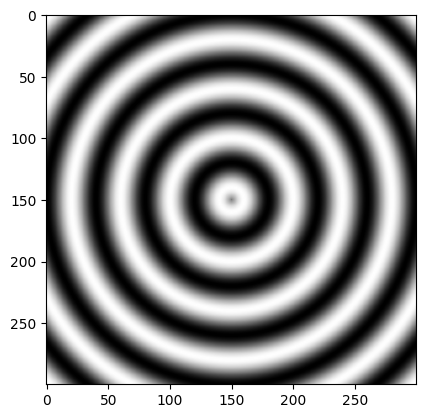

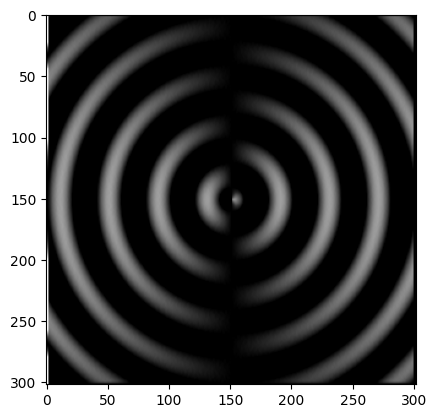

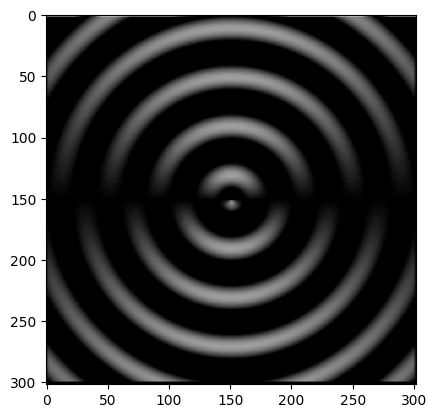

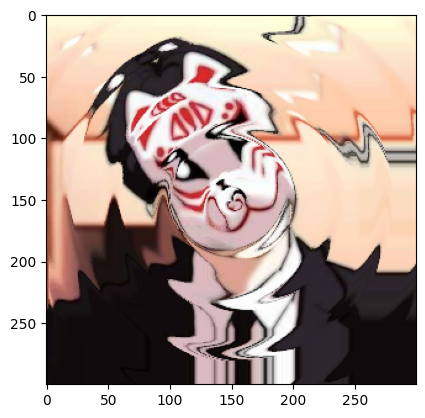

In [15]:

 
imgOndas = crearimgOndas(400, 10, original.shape[0] , original.shape[1] )
imgOndas = np.array(imgOndas)


extOndas, filasfg , columnasfg = crearExtendida(imgOndas)



Gx = convolution(extOndas, filasfg , columnasfg , rows, cols, Sx)
Gx = Image.fromarray(Gx.astype(np.uint8)) 


Gy = convolution(extOndas, filasfg , columnasfg , rows, cols, Sy)
Gy = Image.fromarray(Gy.astype(np.uint8))

plt.imshow(imgOndas)
plt.show()

plt.imshow(Gx)
plt.show()



plt.imshow(Gy)
plt.show()



imgResultante = transformacion(original, extOndas, np.array(Gx, dtype= int), np.array(Gy, dtype= int), 0.001)

plt.imshow(imgResultante.astype(np.uint8))
plt.show()
